### Import the libraries

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.animation import FuncAnimation

### Generate the synthetic data for drone position and direction
$
x = r_x cos(\theta) \\
y = r_y sin(\theta) \\
z = h\theta \\
$

In [89]:
rx = 4
ry = 6
h = 0.5

thetas = np.linspace(0, 4 * np.pi, 200)

x = rx * np.cos(thetas)
y = ry * np.sin(thetas)
z = h * thetas
positions = np.stack([x, y, z], axis=1)

# imaginary target object's position
targets = np.stack([np.zeros_like(z), z / 4, np.zeros_like(z)], axis=1)

# direction (n) vectors
nv = targets - positions
nv /= np.linalg.norm(nv, axis=1, keepdims=True)  # normalize each row

trajectory = np.concatenate([positions, nv], axis=1)

print(trajectory.shape) 

(200, 6)


### Plot without directions just to see the trajectory

In [90]:
def plot_trajectory_without_directions(trajectory: np.array):
    ax = plt.figure().add_subplot(projection='3d')
    x, y, z = trajectory[:, 0], trajectory[:, 1], trajectory[:, 2]
    ax.plot(x, y, z, label='Drone Trajectory')
    ax.legend()
    plt.show()

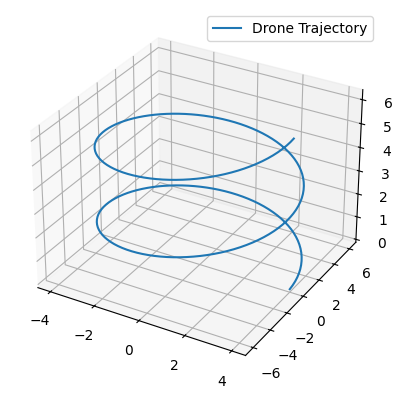

In [91]:
plot_trajectory_without_directions(trajectory=trajectory)

### Plot with the directions

In [92]:
def plot_trajectory_with_directions(trajectory: np.array):
    ax = plt.figure().add_subplot(projection='3d')

    x, y, z = trajectory[:, 0], trajectory[:, 1], trajectory[:, 2]
    nv = trajectory[:, 3:6]

    ax.plot(x, y, z, label='Drone Trajectory', color='blue')

    # plot direction vectors
    # plot every Nth vector
    N = 10
    ax.quiver(
        x[::N], y[::N], z[::N],                 # start positions
        nv[::N, 0], nv[::N, 1], nv[::N, 2],     # vector directions
        length=1.0, normalize=True, color='red'
    )

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.show()


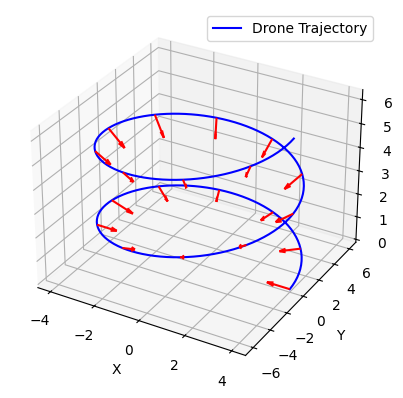

In [93]:
plot_trajectory_with_directions(trajectory=trajectory)

### Add some noise to the data

In [94]:
noise_factor = 0.08
trajectory_noisy = trajectory + noise_factor * np.random.normal(size=trajectory.shape)

### Plot the noisy data

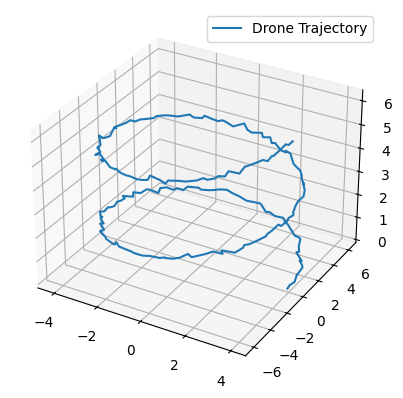

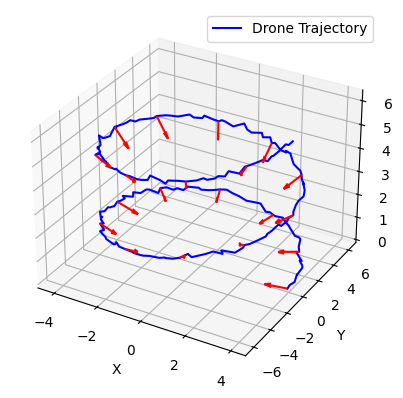

In [99]:
plot_trajectory_without_directions(trajectory=trajectory_noisy)
plot_trajectory_with_directions(trajectory=trajectory_noisy)

### Save generated data as a compressed .npz file

In [96]:
np.savez_compressed(
    "drone_trajectory.npz",
    trajectory=trajectory,
    trajectory_noisy=trajectory_noisy,
    noise_factor=noise_factor
)

### Additionally generate an animation video to intuatively understand the data (Below part is mostly AI guided due to handle video generating better)

Saved as 'drone_animation.mp4'


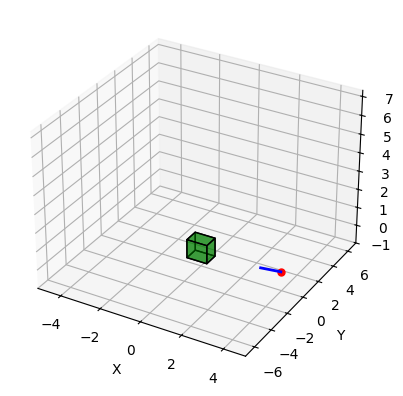

In [98]:
# load trajectory from .npz
data = np.load('drone_trajectory.npz')
trajectory = data.get('trajectory_noisy')
positions = trajectory[:, :3]
nv = trajectory[:, 3:6]  # direction vectors

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# cube at origin as a referance target object
cube_center = np.array([0, 0, 0])
cube_size = 1
r = cube_size / 2
points = np.array([[x, y, z] for x in [-r, r] for y in [-r, r] for z in [-r, r]])
faces = [
    [points[0], points[1], points[3], points[2]],
    [points[4], points[5], points[7], points[6]],
    [points[0], points[1], points[5], points[4]],
    [points[2], points[3], points[7], points[6]],
    [points[0], points[2], points[6], points[4]],
    [points[1], points[3], points[7], points[5]]
]
ax.add_collection3d(Poly3DCollection(faces, facecolors='green', linewidths=1, edgecolors='k', alpha=0.5))

# Drone marker and direction line
drone_dot, = ax.plot([], [], [], 'ro', markersize=5)
dir_line, = ax.plot([], [], [], 'b', linewidth=2)

# Set axes limits
margin = 1
ax.set_xlim(np.min(positions[:,0])-margin, np.max(positions[:,0])+margin)
ax.set_ylim(np.min(positions[:,1])-margin, np.max(positions[:,1])+margin)
ax.set_zlim(np.min(positions[:,2])-margin, np.max(positions[:,2])+margin)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Update function
def update(frame):
    pos = positions[frame]
    n = nv[frame]

    # Drone position
    drone_dot.set_data([pos[0]], [pos[1]])
    drone_dot.set_3d_properties([pos[2]])

    # Direction vector (scaled for visibility)
    line_length = 1.0
    line_end = pos + n * line_length
    dir_line.set_data([pos[0], line_end[0]], [pos[1], line_end[1]])
    dir_line.set_3d_properties([pos[2], line_end[2]])

    return drone_dot, dir_line

# Animate
anim = FuncAnimation(fig, update, frames=len(positions), interval=50, blit=False)

# Save video
anim.save('drone_animation.mp4', writer='ffmpeg', fps=20)
print("Saved as 'drone_animation.mp4'")
